In [409]:
import os
import skimage
from skimage import feature, transform, filters, draw
import keras
import numpy as np
import math

import matplotlib.pyplot as plt
import ipywidgets as widgets

import skimage.transform.hough_transform as ht

# Load images
Also contains approximate transform to grayscale (i.e. just take the green channel)

In [2]:
files = os.listdir("images")
print(len(files))
imsize = (1008, 3038//4)
images = np.zeros((len(files), imsize,imsize))
i = 0
for name in files: 
    tmp = skimage.io.imread(os.path.join("images", name))
    images[i] = transform.resize(tmp, (imsize), anti_aliasing=True)[:,:,1]
    i += 1
    print("done loading image",i)

21


C:\Users\Jon\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


done loading image 1
done loading image 2
done loading image 3
done loading image 4
done loading image 5
done loading image 6
done loading image 7
done loading image 8
done loading image 9
done loading image 10
done loading image 11
done loading image 12
done loading image 13
done loading image 14
done loading image 15
done loading image 16
done loading image 17
done loading image 18
done loading image 19
done loading image 20
done loading image 21


In [162]:
def calc_edges(image):
    return feature.canny(skimage.img_as_float(image), sigma=5, high_threshold=0.95, low_threshold=0.1, use_quantiles=True)

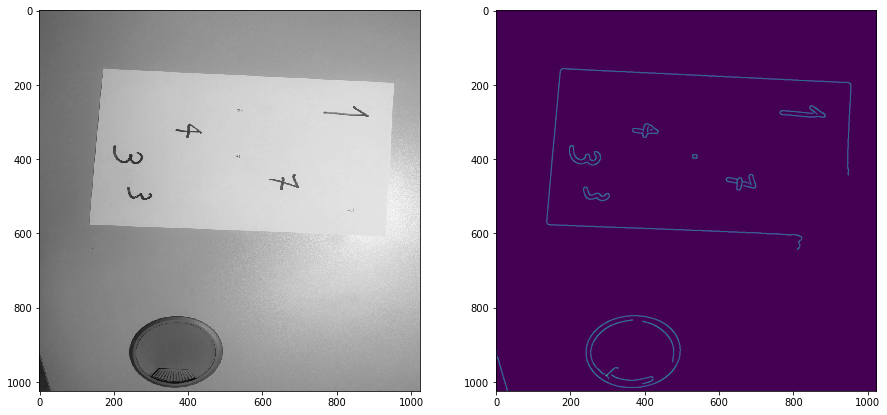

In [310]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
image = images[20]
ax0.imshow(image, cmap="gray")
ax1.imshow(calc_edges(image), interpolation='bilinear')

## Preprocessing for a single image

In [552]:
image = images[2]
edges = calc_edges(image)

In [589]:
lines = transform.probabilistic_hough_line(edges, threshold=100, line_length=350, line_gap=150)

In [590]:
len(lines)

4

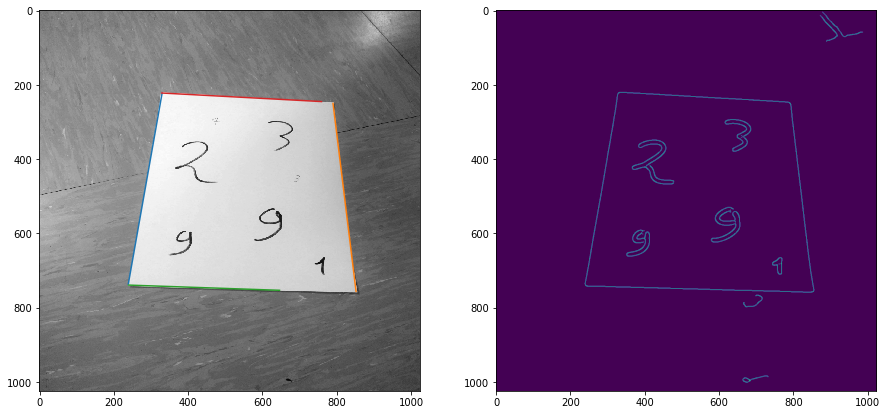

In [591]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(image, cmap="gray")
ax1.imshow(edges, interpolation='bilinear')
for ((x0,y0),(x1,y1)) in lines[0:6]:
    ax0.plot([x0,x1],[y0,y1])

In [429]:

def to_line(line):
    ((x0,y0),(x1,y1)) = line
    lab = np.cross(np.array([x0,y0,1]), np.array([x1, y1, 1]))
    return lab

def get_angle(l0, l1):
    dot = np.dot(l0, l1)
    return np.arccos(dot/magnitude)

def get_magnitude(l0):
    sum = np.sum(np.square(l0))
    return np.sqrt(sum)

def get_intersection(l0, l1):
    i = np.cross(l0, l1)
    i = i / i[2]
    return i[0:2]



In [445]:
my_lines = np.zeros((len(lines),3))
for i in range(0, len(lines)):
    l = to_line(lines[i])
    my_lines[i] = l
    l0 = my_lines[0]
    
mag = np.sqrt(np.sum(np.square(my_lines[:, 0:2]), axis=1))
l0_unit = l0[0:2]/mag[0]
angles = np.arccos(np.sum(np.multiply(l0_unit, my_lines[:, 0:2]), axis=1)/mag)
angles[0] = math.pi
opposite = np.argmin(np.abs(angles))

In [603]:
intersections = np.zeros((4, 2))
j = 0;
for i in range(1, 4):
    if not i == opposite:
        intersections[j] = get_intersection(l0, my_lines[i])
        j = j + 1
l_opposite = my_lines[opposite]
for i in range(1, 4):
    if not i == opposite:
        intersections[j] = get_intersection(l_opposite, my_lines[i])
        j = j + 1

In [606]:
intersections = np.round(intersections)
intersections

array([[238., 739.],
       [330., 222.],
       [853., 760.],
       [790., 247.]])

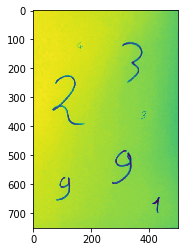

In [612]:
w,h = 500,750
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])

c = np.asarray([
    intersections[0],
    intersections[2],
    intersections[3],
    intersections[1]
])

tf = transform.estimate_transform("projective",
                                  src = c,
                                  dst=np.vstack((A,B,C,D)))
tim = skimage.transform.warp(image=image, inverse_map=tf.inverse, output_shape=(h,w))
plt.imshow(tim)

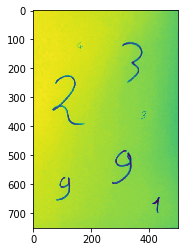

In [607]:
intersections.shape

(4, 2)

In [609]:
c

array([[238., 739.],
       [853., 760.],
       [790., 247.],
       [330., 222.]])